In [1]:
#import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time, warnings
import datetime as dt

In [2]:
!git clone https://github.com/yodialfa/Segmentation_Recomendation


Cloning into 'Segmentation_Recomendation'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 134 (delta 30), reused 45 (delta 24), pack-reused 78
Receiving objects: 100% (134/134), 91.04 MiB | 28.69 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 45.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=7724ad26f38bcaeec17682ba72447d4a0732cf7a5309efcaf28373a599f8d2e1
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


# Data Understanding

Okay, in this time we will built product reccomendation using Colaborative Filtering. First I will tell the data.
here I have some data that I found from kaggle.com and here the resources : https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset. But I've cleaning the data before in customer Segmentation. And now the data has add any features.
the data has Atribute InvoceeNo, StockCode, Description, Quantity, UnitPrice, CustomerID, and Country.
Data Dictionary : <br>
- InvoiceNo : number code of the transacation
- StockCode : the code of item
- Description : dthe description of item
- Quantity : count of item buying.
- InvoiceDate : date of customers transcation full with the time.
- UnitPrice : the price per item.
- CustomerID : ID of customers
- Country : country of customers live.
- TotalTrx : total transcation (quantity x UnitPricce)
- invDate : date without time
- year : year of transaction
- month : month of transaction
- day : day of transaction
- cluster : cluster of customerID
- class : class of customerID (cluster description)

In [ ]:
#load dataset
df_cleaned = pd.read_csv('cleaned_df.csv')
rfmdf = pd.read_csv('cust_seg.csv')

In [ ]:
df_cleaned.head(2)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalTrx,invDate,year,month,day,hour,cluster,class,encust,encprod,qtylog
0,42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.5,2011-01-04,2011,1,4,10,1,Middle Spending Active customers,708,1608,1.00000
1,42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5,2011-01-04,2011,1,4,10,1,Middle Spending Active customers,708,443,1.39794


In [ ]:
#data understanding
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371722 entries, 0 to 371721
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   371722 non-null  int64  
 1   InvoiceNo    371722 non-null  int64  
 2   StockCode    371722 non-null  object 
 3   Description  371722 non-null  object 
 4   Quantity     371722 non-null  int64  
 5   InvoiceDate  371722 non-null  object 
 6   UnitPrice    371722 non-null  float64
 7   CustomerID   371722 non-null  float64
 8   Country      371722 non-null  object 
 9   TotalTrx     371722 non-null  float64
 10  invDate      371722 non-null  object 
 11  year         371722 non-null  int64  
 12  month        371722 non-null  int64  
 13  day          371722 non-null  int64  
 14  hour         371722 non-null  int64  
 15  cluster      371722 non-null  int64  
 16  class        371722 non-null  object 
 17  encust       371722 non-null  int64  
 18  encprod      371722 non-

In [ ]:
rfmdf.head()

,Unnamed: 0,CustomerID,recency,frequency,monetary,cluster,class,qtylog
0,0,12346.0,325,0.301030,4.887531,0,Best customers,NaN
1,1,12347.0,2,2.181844,3.556207,3,New Customers,NaN
2,2,12348.0,75,1.176091,2.956860,1,Middle Spending Active customers,NaN
3,3,12349.0,18,1.869232,3.245155,1,Middle Spending Active customers,NaN
4,4,12350.0,310,1.255273,2.525563,0,Best customers,NaN


In [ ]:
#total rows and columns
df_cleaned.shape


(371722, 20)

In [ ]:
#check unique value for each columns
df_cleaned.nunique()

Unnamed: 0     371722
InvoiceNo       17128
StockCode        3595
Description      3519
Quantity          289
InvoiceDate     15985
UnitPrice         428
CustomerID       4217
Country            36
TotalTrx         2730
invDate           285
year                1
month              12
day                31
hour               15
cluster             4
class               4
encust           4217
encprod          3519
qtylog            289
dtype: int64

In [ ]:
#check value counts in country columns
df_cleaned['Country'].value_counts()

United Kingdom          330374
Germany                   8528
France                    7907
EIRE                      6903
Spain                     2409
Netherlands               2287
Belgium                   1936
Switzerland               1792
Portugal                  1346
Australia                 1150
Norway                     924
Channel Islands            731
Italy                      718
Finland                    668
Cyprus                     531
Sweden                     425
Austria                    390
Denmark                    360
Poland                     322
Japan                      256
Israel                     248
Unspecified                244
Singapore                  222
USA                        179
Iceland                    151
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Brazil  

In [ ]:
#check total of missing value
df_cleaned.isna().sum()

Unnamed: 0     0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalTrx       0
invDate        0
year           0
month          0
day            0
hour           0
cluster        0
class          0
encust         0
encprod        0
qtylog         0
dtype: int64

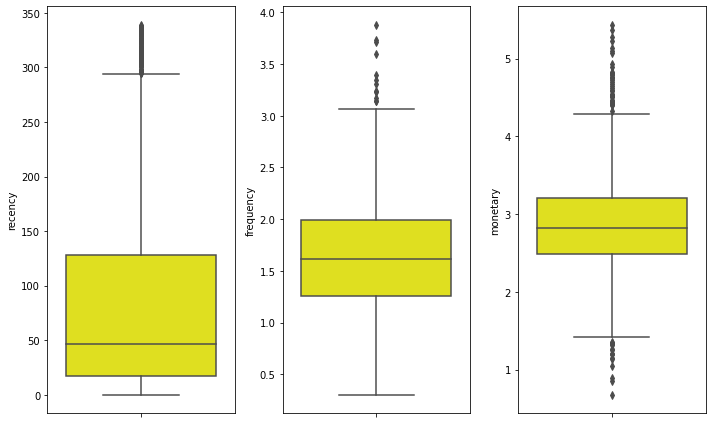

In [ ]:
#define variable of column to figure out visualization
val = ['recency','frequency','monetary']
# adjust the figure size for better readability
plt.figure(figsize=(10,6))
# plotting
for i in range(0, len(val)):
    plt.subplot(1, len(val), i+1)
    sns.boxplot(y=rfmdf[val[i]], color='yellow')
    plt.tight_layout()


the data has outlers, but we'll keep it, because that's data transaction.

In [ ]:
# # def check_outlier(data, column):
# def check_outlier(data, column):
#     q1 = data[column].quantile(0.25)
#     q3 = data[column].quantile(0.75)
#     iqr = q3 - q1
    
#     return ['outlier' if (x<q1-1.5*iqr or x>q3+1.5*iqr) 
#                                  else 'not-outlier' for x in data[column].values]


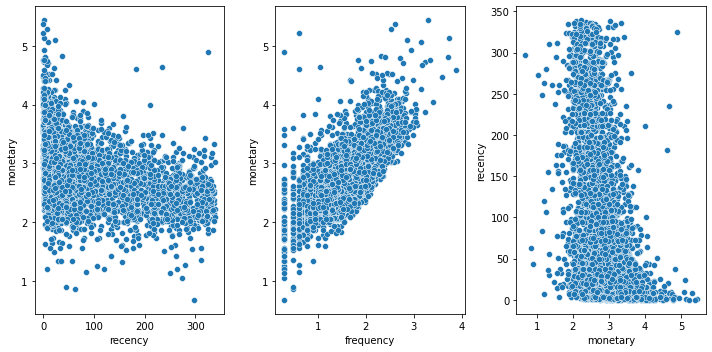

In [ ]:
#scatter of data 
fig, axes = plt.subplots(1,3, figsize=(10,5))
sns.scatterplot(ax=axes[0],data=rfmdf,x='recency', y='monetary')
sns.scatterplot(ax=axes[1],data=rfmdf,x='frequency', y='monetary')
sns.scatterplot(ax=axes[2],data=rfmdf,y='recency', x='monetary')
plt.tight_layout()

In [ ]:

# df['rating'] = [0.5 if (x>0 and x < 3 and y > 0 and y <=1) else
#                 1 if (x>=3 and x<=5 and y > 0 and y <= 1) else
#                 1.5 if (x>5 and  x<=7 and y >0 and y <= 1) else
#                 2 if (x>0 and x < 3 and y > 1 and y <= 3) else
#                 2.5 if (x>0 and x < 3 and y > 3 and y <= 5) else
#                 3 if (x>5 and x<=7 and y > 3 and y <= 5) else
#                 3.5 if (x>0 and x <= 10  and y >0 ) else
#                 4 if (x>10 and x <= 20 and y > 0 and y <= 10) else 
#                 4.5 if (x>10 and x<=20 and y >10 )else
#                 5 if (x>20  and y > 0) else 'none' for x,y in zip(df['Quantity'], df['UnitPrice'])]

In [ ]:
# df.rating.value_counts()

In [ ]:
# af = np.arange(0.5,5.5,0.5)

# for z in af:
#     dd = df[df['rating']==z]
#     print('Min Transaction in Rating',z,'is',dd.TotalTrx.min())
#     print('Max Transaction in Rating',z,'is',dd.TotalTrx.max(),'\n')

In [ ]:
# #grouping StockCode 
# product_code = df.groupby(['StockCode','Description']).agg(number_of_ratings = ('rating', 'sum')).reset_index()
# #sorted by counts 
# product_code = product_code.sort_values(by=['number_of_ratings'],ascending=False)

# product_code.head()

In [ ]:
# product_code.sort_values(by='number_of_ratings',ascending=False)

In [ ]:
df_baskets = df_cleaned[['InvoiceNo', 'StockCode', 'Description', 'Quantity']]
df_baskets.head()

,InvoiceNo,StockCode,Description,Quantity
0,539993,22386,JUMBO BAG PINK POLKADOT,10
1,539993,21499,BLUE POLKADOT WRAP,25
2,539993,21498,RED RETROSPOT WRAP,25
3,539993,22379,RECYCLING BAG RETROSPOT,5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10


In [ ]:
df_cleaned.groupby('Description').agg(
    orders=('InvoiceNo', 'nunique'),
    quantity=('Quantity', 'sum')
).sort_values(by='orders', ascending=False).head(10)

,orders,quantity
Description,,
MAILOUT,1945,43236
WHITE HANGING HEART T-LIGHT HOLDER,1777,33171
REGENCY CAKESTAND 3 TIER,1566,10832
JUMBO BAG RED RETROSPOT,1517,44125
PARTY BUNTING,1356,15101
ASSORTED COLOUR BIRD ORNAMENT,1284,33095
LUNCH BAG RED RETROSPOT,1235,17249
SET OF 3 CAKE TINS PANTRY DESIGN,1099,6808
POSTAGE,1035,2900


In [ ]:
df_items = df_cleaned.pivot_table(index='InvoiceNo', columns=['Description'], values='Quantity').fillna(0)
df_items.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,...,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17128 entries, 539993 to 581587
Columns: 3519 entries,  4 PURPLE FLOCK DINNER CANDLES to ZINC WIRE SWEETHEART LETTER TRAY
dtypes: float64(3519)
memory usage: 460.0 MB


In [ ]:
def get_recommendations(df, item):
    """Generate a set of product recommendations using item-based collaborative filtering.
    
    Args:
        df (dataframe): Pandas dataframe containing matrix of items purchased.
        item (string): Column name for target item. 
        
    Returns: 
        recommendations (dataframe): Pandas dataframe containing product recommendations. 
    """
    
    recommendations = df.corrwith(df[item])
    recommendations.dropna(inplace=True)
    recommendations = pd.DataFrame(recommendations).reset_index()
    recommendations = recommendations.sort_values(by='correlation', ascending=False)
    recommendations = recommendations.iloc[1:]
    
    return recommendations

In [ ]:
# recommendations = get_recommendations(df_items, 'ZINC WIRE SWEETHEART LETTER TRAY')
# recommendations.head()

In [ ]:
# recommendations = df_items.corrwith(df_items['OVAL WALL MIRROR DIAMANTE'])
# recommendations.dropna(inplace=True)
# recommendations = pd.DataFrame(recommendations, columns=['correlation']).reset_index()
# recommendations

In [ ]:
# recommendations = recommendations.sort_values(by='correlation', ascending=False)
# recommendations

In [ ]:
# recommendations = recommendations[1:]
# recommendations.head()

In [4]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib inlineimport os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import *
from pyspark import SparkContext

from pyspark import  SparkConf , SparkContext
from pyspark.context import  SparkContext

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# conf = SparkConf().setAppName(appName).setMaster(master)

spark = SparkSession.builder.config("spark.driver.host","localhost").appName('RecomendationSystem').getOrCreate()
# # get spark context
# sc = spark.sparkContext()
# sc = SparkContext(master = "local" , appName = "sparkdemo")
# spark = SparkSession(sc)

In [5]:
from pyspark import SparkConf 
from pyspark.context import SparkContext 

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [6]:
# import findspark
# findspark.init()

In [7]:
# path = "/C:/Yodi/REKAP/Modul Data Science/Final Project/Segmentation_Recomendation/Segmentation_Recomendation/cleaned_df.csv"

df = spark.read.csv('Segmentation_Recomendation/cleaned_df.csv',header='true', 
                      inferSchema='true')
# df = spark.read.csv('cleaned_df.csv')
df.show(3)

+-----+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------+-------------------+----+-----+---+----+-------+--------------------+------+-------+------------------+
|  _c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|TotalTrx|            invDate|year|month|day|hour|cluster|               class|encust|encprod|            qtylog|
+-----+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+--------+-------------------+----+-----+---+----+-------+--------------------+------+-------+------------------+
|42481|   539993|    22386|JUMBO BAG PINK PO...|      10|2011-01-04 10:00:00|     1.95|   13313.0|United Kingdom|    19.5|2011-01-04 00:00:00|2011|    1|  4|  10|      1|Middle Spending A...|   708|   1608|               1.0|
|42482|   539993|    21499|  BLUE POLKADOT WRAP|      25|2011-01-04 10:00:00|     0.42|   13313.

In [8]:
# getting column encprod and description
prd = df.select(df['encprod'],df['Description'])
# Select distinct rows
prod_df = prd.distinct()
#show data
prod_df.show(truncate=False)
#getiing length row and column of data
print((prod_df.count(), len(prod_df.columns)))

+-------+----------------------------------+
|encprod|Description                       |
+-------+----------------------------------+
|2638   |ROUND SNACK BOXES SET OF 4 SKULLS |
|2497   |RED RETROSPOT CHARLOTTE BAG       |
|3075   |STRAWBERRY LUNCH BOX WITH CUTLERY |
|1544   |INFLATABLE POLITICAL GLOBE        |
|686    |CHRISTMAS GINGHAM HEART           |
|2872   |SET/6 COLLAGE PAPER PLATES        |
|556    |CANDY SPOT EGG WARMER RABBIT      |
|1673   |LARGE CHINESE STYLE SCISSOR       |
|1321   |GLITTER HEART GARLAND WITH BELLS  |
|426    |BLUE PAISLEY TISSUE BOX           |
|504    |BROWN  PIRATE TREASURE CHEST      |
|511    |BULL DOG BOTTLE TOP WALL CLOCK    |
|1770   |LUNCH BAG ALPHABET DESIGN         |
|1569   |IVORY SWEETHEART WIRE LETTER RACK |
|1662   |LARGE ANTIQUE WHITE PHOTO FRAME   |
|2745   |SET OF 3 CAKE TINS PANTRY DESIGN  |
|3474   |WRAP RED APPLES                   |
|691    |CHRISTMAS HANGING STAR WITH BELL  |
|1203   |FRENCH BLUE METAL DOOR SIGN 6     |
|498    |B

In [9]:
# from pyspark.sql.functions import sum,avg,max
import pyspark.sql.functions as sf
#define rating data
# nd = df.select(df['encprod'],df['encprod'],df['qtylog'])

nd = df.groupBy("encust","encprod")\
   .agg(sf.sum('Quantity').alias('qty'),\
        sf.sum('TotalTrx').alias('grand')
        )



In [10]:
nd.show(2)

+------+-------+---+-----------------+
|encust|encprod|qty|            grand|
+------+-------+---+-----------------+
|  4005|   1473|  6|9.899999999999999|
|   966|   2155|  5|             4.25|
+------+-------+---+-----------------+
only showing top 2 rows



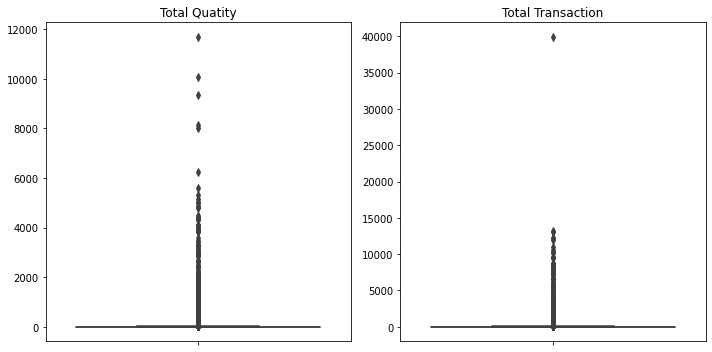

In [11]:
arr_qty = np.array(nd.select('qty').collect())
arr_grand = np.array(nd.select('grand').collect())
# arrencprod = nd.select('encprod')
# arrqtylog = arrqtylog.tolist()
# plot
# plt.figure(figsize=(12, 6))
# fig1, ax1 = plt.subplots()
# ax1.set_title('Qty BoxPlot')
# ax1.boxplot(arrqtylog)
# sns.boxplot(y=arrqty)


fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(ax=axes[0],y = arr_qty).set(title='Total Quatity')
sns.boxplot(ax=axes[1],y = arr_grand).set(title='Total Transaction')
plt.tight_layout()

In [12]:
#logtransform to reduce outlier
from pyspark.sql.functions import col
nd = nd.withColumn("logqty", log10(col("qty")))
nd = nd.withColumn("logtrx", log10(col("grand")))

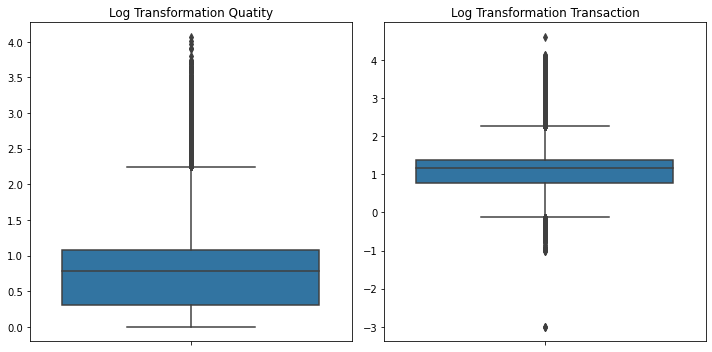

In [13]:
arr_logqty = np.array(nd.select("logqty").collect())
arr_logtrx = np.array(nd.select("logtrx").collect())
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(ax=axes[0],y = arr_logqty).set(title='Log Transformation Quatity')
sns.boxplot(ax=axes[1],y = arr_logtrx).set(title='Log Transformation Transaction')
plt.tight_layout()

In [14]:
data_scale_output = nd.select(nd['encust'],nd['encprod'],nd['logqty'],nd['logtrx'])
data_scale_output.show(2)

+------+-------+------------------+------------------+
|encust|encprod|            logqty|            logtrx|
+------+-------+------------------+------------------+
|  4005|   1473|0.7781512503836436|0.9956351945975499|
|   966|   2155|0.6989700043360189|0.6283889300503115|
+------+-------+------------------+------------------+
only showing top 2 rows



In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [16]:
#format the data
data_scale_output.columns

['encust', 'encprod', 'logqty', 'logtrx']

In [17]:
vec_assembler = VectorAssembler(inputCols=["logqty", "logtrx"], outputCol="features")

In [18]:
# vec_assembler = VectorAssembler(inputCols = data_scale_output.columns, outputCol='features')

In [19]:
final_data = vec_assembler.transform(data_scale_output)

In [20]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [21]:
final_data.show(2)

+------+-------+------------------+------------------+--------------------+
|encust|encprod|            logqty|            logtrx|            features|
+------+-------+------------------+------------------+--------------------+
|  4005|   1473|0.7781512503836436|0.9956351945975499|[0.77815125038364...|
|   966|   2155|0.6989700043360189|0.6283889300503115|[0.69897000433601...|
+------+-------+------------------+------------------+--------------------+
only showing top 2 rows



In [22]:
# Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(final_data)

In [23]:
# Normalize each feature to have unit standard deviation.
# final_data = scalerModel.transform(final_data)

# Training Data Kmeans

In [24]:
from pyspark.ml.clustering import KMeans

# Training a k-means model.
# kmeans = KMeans(featuresCol='scaledFeatures',k=3)
# model = kmeans.fit(final_data)

In [25]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(final_data)
    
    output=KMeans_fit.transform(final_data)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.6062167513804508
Silhouette Score: 0.6102063114676449
Silhouette Score: 0.5501809627182896
Silhouette Score: 0.5146735798774673
Silhouette Score: 0.5142315280474207
Silhouette Score: 0.4743767705985992
Silhouette Score: 0.5009300465018786
Silhouette Score: 0.4990159071625255


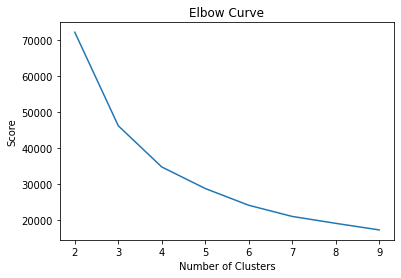

In [26]:
# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [50]:
final_data.show(2)

+------+-------+------------------+------------------+--------------------+
|encust|encprod|            logqty|            logtrx|            features|
+------+-------+------------------+------------------+--------------------+
|  4005|   1473|0.7781512503836436|0.9956351945975499|[0.77815125038364...|
|   966|   2155|0.6989700043360189|0.6283889300503115|[0.69897000433601...|
+------+-------+------------------+------------------+--------------------+
only showing top 2 rows



In [54]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [51]:
kdata = final_data.select(final_data['logqty'],final_data['logtrx'])
kdata = kdata.toPandas()
kdata.head()

,logqty,logtrx
0,0.778151,0.995635
1,0.698970,0.628389
2,1.255273,1.577492
3,1.778151,1.895423
4,1.079181,1.176091


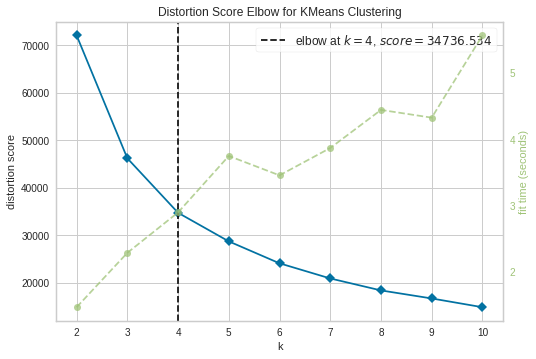

In [52]:
#visualization
elbow_graph = KElbowVisualizer(KMeans(), k=10)
elbow_graph.fit(kdata)
elbow_graph.show()

In [27]:
# kmeans = KMeans(k=4, seed=1)
model = KMeans(featuresCol='features',k=4, seed=1)
KMeans_fit=model.fit(final_data)
output=KMeans_fit.transform(final_data)
output.show()

+------+-------+------------------+------------------+--------------------+----------+
|encust|encprod|            logqty|            logtrx|            features|prediction|
+------+-------+------------------+------------------+--------------------+----------+
|  4005|   1473|0.7781512503836436|0.9956351945975499|[0.77815125038364...|         2|
|   966|   2155|0.6989700043360189|0.6283889300503115|[0.69897000433601...|         2|
|   966|    677| 1.255272505103306|1.5774917998372253|[1.25527250510330...|         3|
|  3194|    454|1.7781512503836436|1.8954225460394079|[1.77815125038364...|         0|
|   667|     76|1.0791812460476249|1.1760912590556813|[1.07918124604762...|         3|
|  3677|    942|1.6989700043360187|2.5282737771670436|[1.69897000433601...|         0|
|  1930|   1426|1.6812412373755872| 1.842609239610562|[1.68124123737558...|         0|
|  1920|    754|0.9542425094393249|1.1427022457376155|[0.95424250943932...|         3|
|   319|    631|               0.0| 1.10551

In [28]:
output.take(5)

[Row(encust=4005, encprod=1473, logqty=0.7781512503836436, logtrx=0.9956351945975499, features=DenseVector([0.7782, 0.9956]), prediction=2),
 Row(encust=966, encprod=2155, logqty=0.6989700043360189, logtrx=0.6283889300503115, features=DenseVector([0.699, 0.6284]), prediction=2),
 Row(encust=966, encprod=677, logqty=1.255272505103306, logtrx=1.5774917998372253, features=DenseVector([1.2553, 1.5775]), prediction=3),
 Row(encust=3194, encprod=454, logqty=1.7781512503836436, logtrx=1.8954225460394079, features=DenseVector([1.7782, 1.8954]), prediction=0),
 Row(encust=667, encprod=76, logqty=1.0791812460476249, logtrx=1.1760912590556813, features=DenseVector([1.0792, 1.1761]), prediction=3)]

In [29]:
nd = output.select(output['encust'],output['encprod'],output['prediction'])

In [30]:
nd.show(2)

+------+-------+----------+
|encust|encprod|prediction|
+------+-------+----------+
|  4005|   1473|         2|
|   966|   2155|         2|
+------+-------+----------+
only showing top 2 rows



In [31]:
# convert dataframe to rdd
rdd = nd.rdd
rdd

MapPartitionsRDD[1429] at javaToPython at NativeMethodAccessorImpl.java:0

In [32]:
# rd = []
# # collect data from the  dataframe
# for i in rdd.collect():
#    rd.append(tuple(i))
   # convert to tuple and append to list

In [33]:
data = rdd.map(tuple)
# data.take(2)
data

PythonRDD[1430] at RDD at PythonRDD.scala:53

In [34]:
#  rdd=spark.sparkContext.parallelize(rd)

In [35]:
# dataColl=rdd.collect()

In [36]:
data.take(2)

[(4005, 1473, 2), (966, 2155, 2)]

In [37]:
train, validation, test = data.randomSplit([.6, .2, .2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[1434] at RDD at PythonRDD.scala:53

In [38]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (encust, enctprod, qtylog) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [39]:
# hyper-param config
num_iterations = 10
ranks = [20,50,100]
reg_params = [ 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 latent factors and regularization = 0.01: validation RMSE is 1.106612668230327
20 latent factors and regularization = 0.05: validation RMSE is 0.8884571735723852
20 latent factors and regularization = 0.1: validation RMSE is 0.8348978928649736
20 latent factors and regularization = 0.2: validation RMSE is 0.8357110913866176
50 latent factors and regularization = 0.01: validation RMSE is 1.0103233409673376
50 latent factors and regularization = 0.05: validation RMSE is 0.8601728532689794
50 latent factors and regularization = 0.1: validation RMSE is 0.829443568380284
50 latent factors and regularization = 0.2: validation RMSE is 0.8357865788921208

The best model has 50 latent factors and regularization = 0.1
Total Runtime: 389.21 seconds


In [40]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

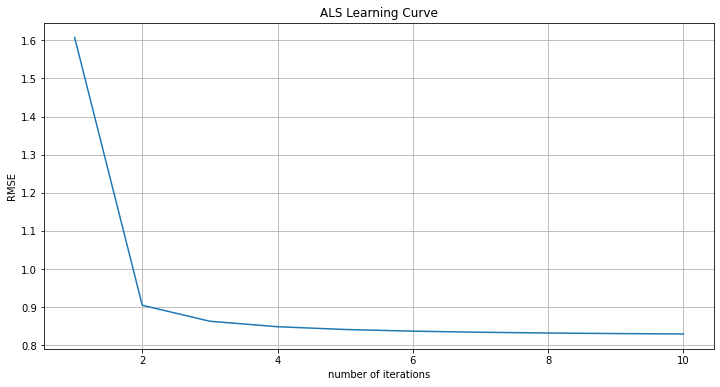

In [41]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.1, 50)

In [42]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', error)

The out-of-sample RMSE of rating predictions is 0.8289320259848187


In [43]:
test.take(2)

[(554, 3236, 2), (3092, 1554, 2)]

In [44]:
def get_prod(prod_df, fav_prod_list):
    """
    return all product(encprod)(s) of user's favorite product
    
    Parameters
    ----------
    prod_df: spark Dataframe, product data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    prod_list: list of productid(encprod)(s)
    """
    prod_list = []
    for prod in fav_prod_list:
        prodIds = prod_df \
            .filter(prod_df.Description.like('%{}%'.format(prod))) \
            .select('encprod') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        prod_list.extend(prodIds)
    return list(set(prod_list))


def add_new_user_to_data(train_data, prod_list, spark_context):
    """
    add new rows with new user, user's product and ratings(qtylog) to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    prod_list: list, list of product id(encprod)(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new customer id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new customer rdd
    user_rows = [(new_id, encprod, max_rating) for encprod in prod_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, prod_df, prod_list):
    """
    return a rdd with the encust and all product(except ones in prod_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    prod_df: spark Dataframe, product data
    
    prod_list: list, list of product(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return prod_df.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in prod_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, prod_df, 
                        fav_prod_list, n_recommendations, spark_context):
    """
    return top n product recommendation based on user's input list of product


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    prod_df: spark Dataframe, product data

    fav_prod_list: list, user's list of product

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n product recommendations
    """
    # modify train data by adding new user's rows
    prod_list = get_prod(prod_df, fav_prod_list)
    train_data = add_new_user_to_data(ratings_data, prod_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, prod_df, prod_list
                                      
                                      
                                      )
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n product(encprod)
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return prodcut description
    return prod_df.filter(prod_df.encprod.isin(topn_ids)) \
                    .select('Description') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [45]:
# my product
my_prod = ['JUMBO BAG ALPHABET']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 50, 'lambda_': 0.1}, 
    ratings_data=data, 
    prod_df=prod_df, 
    fav_prod_list=my_prod, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_prod[0]))
for i, Description in enumerate(recommends):
    print('{0}: {1}'.format(i+1, Description))

Recommendations for JUMBO BAG ALPHABET:
1: JUMBO BAG PINK VINTAGE PAISLEY
2: CRYSTAL STUD EARRINGS ASSORTED COL 
3: JUMBO BAG SCANDINAVIAN PAISLEY
4: JUMBO STORAGE BAG SUKI
5: HAIRCLIPS FORTIES FABRIC ASSORTED
6: ANTIQUE GLASS PLACE SETTING
7: JUMBO BAG APPLES
8: JUMBO BAG OWLS
9: WHITE FRANGIPANI HAIR CLIP
10: JUMBO BAG PINK POLKADOT
